In [1]:
import cv2
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

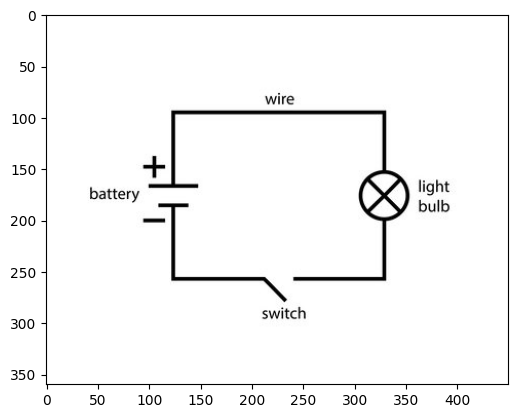

In [39]:
image = cv2.imread('Project/ckt2.jpg')
plt.imshow(image)
fheight, fwidth = image.shape[:2]

In [40]:

def canny_edge_detection(image):
    # Grayscale conversion if needed
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Gaussian Blur
    blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)
    return edges



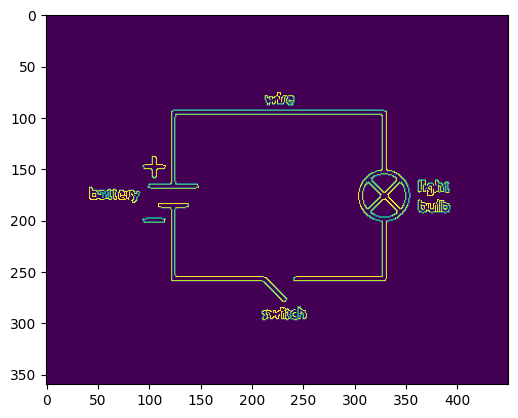

In [41]:
plt.imshow(canny_edge_detection(image))

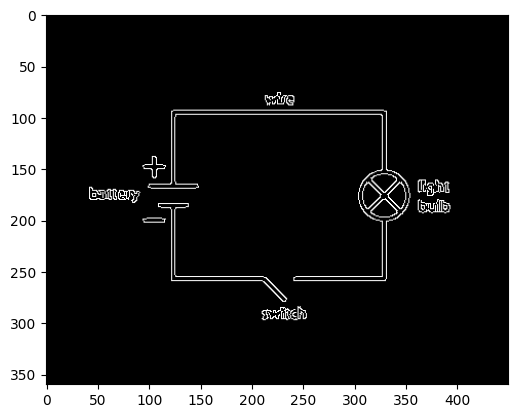

In [42]:
image_gray = cv2.cvtColor(canny_edge_detection(image), cv2.COLOR_GRAY2BGR)
plt.imshow(image_gray)

In [43]:
# Perform Probabilistic Hough Transform
threshold = 100 
min_line_length = 50 
max_line_gap = 10  

In [6]:
# Perform Probabilistic Hough Transform
threshold = 100  # Minimum number of votes to consider a line
min_line_length = 50  # Minimum length of a line
max_line_gap = 10  # Maximum allowed gap between line segments to treat them as a single line

In [44]:
def probabilistic_hough_transform(image_edges, threshold, min_line_length, max_line_gap):
    lines = []  # Store detected lines [(x1, y1, x2, y2), ...]

    height, width = image_edges.shape[:2]

    # Voting space parameters (for simplicity, may not be the best approach)
    rho_max = int(math.hypot(height, width))
    theta_max = 180  # Angle resolution
    accumulator = np.zeros((2 * rho_max, theta_max), dtype=np.uint8)

    edge_points = np.argwhere(image_edges > 0)  # Get edge points

    # Perform voting for lines
    for y, x in edge_points:
        for theta in range(theta_max):
            rho = int(x * math.cos(math.radians(theta)) + y * math.sin(math.radians(theta)))
            accumulator[rho, theta] += 1  # Accumulate votes

    # Threshold accumulator to find lines
    for rho in range(accumulator.shape[0]):
        for theta in range(accumulator.shape[1]):
            if accumulator[rho, theta] > threshold:
                a = math.cos(math.radians(theta))
                b = math.sin(math.radians(theta))
                x0 = a * rho
                y0 = b * rho
                x1 = int(x0 + 1000 * (-b))  # Line length parameters
                y1 = int(y0 + 1000 * (a))
                x2 = int(x0 - 1000 * (-b))
                y2 = int(y0 - 1000 * (a))
                lines.append(((x1, y1), (x2, y2)))  # Store line endpoints

    return lines


In [45]:
lines = probabilistic_hough_transform(canny_edge_detection(image), threshold, min_line_length, max_line_gap)
print("Number of detected lines: ", len(lines))
print(lines)

Number of detected lines:  8
[((-1000, 93), (1000, 92)), ((-1000, 97), (1000, 96)), ((122, 1000), (122, -1000)), ((125, 1000), (125, -1000)), ((-1000, 255), (1000, 254)), ((-1000, 259), (1000, 258)), ((327, 1000), (327, -1000)), ((331, 1000), (331, -1000))]


In [46]:
def find_intersection_points(lines):
    intersection_points = []
    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            line1 = lines[i]
            line2 = lines[j]
            denominator = (
                (line2[1][1] - line2[0][1]) * (line1[1][0] - line1[0][0])
                - (line2[1][0] - line2[0][0]) * (line1[1][1] - line1[0][1])
            )
            if denominator != 0:  # Checking if lines are not almost parallel
                intersection = [
                    (
                        (line2[1][0] - line2[0][0])
                        * (line1[1][0] * line1[0][1] - line1[0][0] * line1[1][1])
                        - (line1[1][0] - line1[0][0])
                        * (line2[1][0] * line2[0][1] - line2[0][0] * line2[1][1])
                    )
                    / denominator,
                    (
                        (line1[0][1] - line1[1][1])
                        * (line2[1][0] * line2[0][1] - line2[0][0] * line2[1][1])
                        - (line2[0][1] - line2[1][1])
                        * (line1[1][0] * line1[0][1] - line1[0][0] * line1[1][1])
                    )
                    / denominator,
                ]
                intersection = np.array(intersection)
                if np.all(0 <= intersection) and np.all(intersection <= 1000):
                    intersection_points.append(intersection.astype(int))

    return np.array(intersection_points) if intersection_points else None


In [47]:
intersection_points = find_intersection_points(lines)
print("Number of intersection points: ", len(intersection_points))
print(intersection_points)

Number of intersection points:  16
[[122  92]
 [125  92]
 [327  92]
 [331  92]
 [122  96]
 [125  96]
 [327  96]
 [331  96]
 [122 254]
 [122 258]
 [125 254]
 [125 258]
 [327 254]
 [331 254]
 [327 258]
 [331 258]]


In [48]:
result = None  # Initialize result to None

In [49]:
def find_significant_nodes(intersection_points):
    clustering = DBSCAN(eps=8, min_samples=4).fit(intersection_points)
    labels = clustering.labels_
    unique_labels = set(labels)
    
    significant_nodes = []
    for label in unique_labels:
        if label != -1:  # Excluding noise points
            cluster = intersection_points[labels == label]
            significant_node = np.mean(cluster, axis=0)
            significant_nodes.append(significant_node)
    
    return significant_nodes

In [50]:
significant_nodes = find_significant_nodes(intersection_points)

In [51]:
display_image = np.copy(image)

In [52]:

for line in lines:
        cv2.line(display_image, line[0], line[1], (0, 255, 0), 2)  # Green lines


if intersection_points is not None:
        for point in intersection_points:
            cv2.circle(display_image, (int(point[0]), int(point[1])), 5, (0, 0, 255), -1)  # Red circles


if significant_nodes:
        for node in significant_nodes:
            cv2.circle(display_image, (int(node[0]), int(node[1])), 3, (255, 0, 0), -1)  # Blue circles
            print(f"Significant Node at: ({int(node[0])}, {int(node[1])})")

Significant Node at: (123, 94)
Significant Node at: (329, 94)
Significant Node at: (123, 256)
Significant Node at: (329, 256)


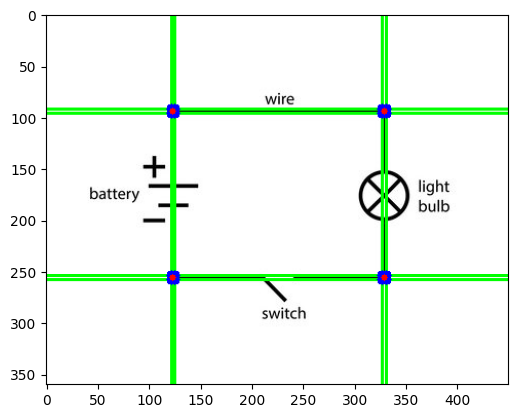

In [53]:
plt.imshow(display_image)